# Natural Language Processing Project

## Goal

## Business Case


In [ ]:
# Data Source: https://data.mendeley.com/datasets/pk5vs5wjxm/1

In [130]:
!pip install transformers datasets torch scikit-learn


   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------- ----------------------- 3.9/9.7 MB 21.3 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.7 MB 25.5 MB/s eta 0:00:01
   ---------------------------------------- 9.7/9.7 MB 23.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 27.3 MB/s eta 0:00:00


In [150]:
# Read in libraries of interest
import pandas as pd
import os

# Python's natural language processing package
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Modeling 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Random Forest -- Simple Model
from sklearn.ensemble import RandomForestClassifier 

# Model Performance
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agbea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agbea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [133]:
# print(os.getcwd())  ### Check where files are read-in from

# Clean and prep data

In [134]:
# Load the dataset
original_df = pd.read_excel("News_recommendation_dataset.xlsx")
original_df.head()

,headlines,newspaper,description,catagories,link
0,MV Abdullah leaves UAE for last leg of homewar...,The Daily Star,"The ship MV Abdullah, with 23 Bangladeshi crew...",Business,https://www.thedailystar.net/Health
1,"Heatwave: After fiery April, milder May beckons",The Daily Star,Relief from a severe heatwave expected in May ...,Weather,https://www.thedailystar.net/Health
2,Bar pharmas from raising medicine prices at will,The Daily Star,High Court orders measures to prevent pharmace...,Healthcare,https://www.thedailystar.net/Health
3,IMF Loan: Govt may miss two key targets set fo...,The Daily Star,Concerns raised over government potentially fa...,Economy,https://www.thedailystar.net/Health
4,Columbia University suspends pro-Palestinian p...,The Daily Star,Disciplinary action taken against pro-Palestin...,Education,https://www.thedailystar.net/Health


In [135]:
original_df.rename(columns ={'catagories': 'categories'}, inplace=True) ### typo in title
original_df.head()

,headlines,newspaper,description,categories,link
0,MV Abdullah leaves UAE for last leg of homewar...,The Daily Star,"The ship MV Abdullah, with 23 Bangladeshi crew...",Business,https://www.thedailystar.net/Health
1,"Heatwave: After fiery April, milder May beckons",The Daily Star,Relief from a severe heatwave expected in May ...,Weather,https://www.thedailystar.net/Health
2,Bar pharmas from raising medicine prices at will,The Daily Star,High Court orders measures to prevent pharmace...,Healthcare,https://www.thedailystar.net/Health
3,IMF Loan: Govt may miss two key targets set fo...,The Daily Star,Concerns raised over government potentially fa...,Economy,https://www.thedailystar.net/Health
4,Columbia University suspends pro-Palestinian p...,The Daily Star,Disciplinary action taken against pro-Palestin...,Education,https://www.thedailystar.net/Health


## Filter the data

I am going to select categories that have at least 40 observations to ensure that there is a decent sample size for modeling. 

In [136]:
# check for missing
print(original_df.isnull().sum())

headlines      0
newspaper      0
description    0
categories     0
link           0
dtype: int64


In [137]:
# Remove leading and trailing spaces from the 'Name' column
original_df['categories'] = original_df['categories'].str.strip()

# Count occurrences of each value
value_counts = original_df['categories'].value_counts()
print(value_counts)


categories
Environment              203
Health                   167
Politics                 149
Economy                  141
Sports                   123
                        ... 
More                       1
Petroleum                  1
Health, Lifestyle          1
Health, International      1
Health, Environment        1
Name: count, Length: 207, dtype: int64


In [138]:
# Filter values that appear at least 40 times
valid_values = value_counts[value_counts >= 40].index
print(valid_values)

Index(['Environment', 'Health', 'Politics', 'Economy', 'Sports', 'Business',
       'Technology', 'Entertainment', 'Education', 'Weather', 'International'],
      dtype='object', name='categories')


In [139]:
# Select observations where the value appears at least 40 times
filtered_df = original_df[original_df['categories'].isin(valid_values)].reset_index(drop=True) ### resetting index for manipulations
filtered_df.head()

,headlines,newspaper,description,categories,link
0,MV Abdullah leaves UAE for last leg of homewar...,The Daily Star,"The ship MV Abdullah, with 23 Bangladeshi crew...",Business,https://www.thedailystar.net/Health
1,"Heatwave: After fiery April, milder May beckons",The Daily Star,Relief from a severe heatwave expected in May ...,Weather,https://www.thedailystar.net/Health
2,IMF Loan: Govt may miss two key targets set fo...,The Daily Star,Concerns raised over government potentially fa...,Economy,https://www.thedailystar.net/Health
3,Columbia University suspends pro-Palestinian p...,The Daily Star,Disciplinary action taken against pro-Palestin...,Education,https://www.thedailystar.net/Health
4,Australia sets out targets in 10-year plan to ...,The Daily Star,Australia introduces goals in a 10-year plan t...,Sports,https://www.thedailystar.net/Health


In [140]:
print("How many observations in filtered df:", len(filtered_df))

How many observations in filtered df: 1281


## Remove noise like stopwords

In [141]:
stop_words = set(stopwords.words('english')) ### identifying stop words in English such as 'a', 'the', 'for', etc. 

In [142]:
def process_text(text):
    text = text.lower() ### lowercase all text
    text = text.translate(str.maketrans('', '', string.punctuation)) ### Remove punctuation
    words = word_tokenize(text) ### tokenize
    words = [word for word in words if word not in stop_words] ### removing the stop words
    return ' '.join(words)

In [143]:
filtered_df['processed_description'] = filtered_df['description'].apply(process_text)

In [144]:
target_encoded = LabelEncoder()
filtered_df['category_encoded'] = target_encoded.fit_transform(filtered_df['categories'])

label_mapping = dict(zip(target_encoded.classes_, target_encoded.transform(target_encoded.classes_)))  # Save for later decoding
print(label_mapping)

{'Business': np.int64(0), 'Economy': np.int64(1), 'Education': np.int64(2), 'Entertainment': np.int64(3), 'Environment': np.int64(4), 'Health': np.int64(5), 'International': np.int64(6), 'Politics': np.int64(7), 'Sports': np.int64(8), 'Technology': np.int64(9), 'Weather': np.int64(10)}


# Split data into train and test 

In [145]:
X = filtered_df['processed_description']
y = filtered_df['category_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [146]:
# Convert Text Data to Numeric Features
vectorized = TfidfVectorizer(max_features=4000)  ### Limit the number of features
X_train_vec = vectorized.fit_transform(X_train)
X_test_vec = vectorized.transform(X_test)

# Train the models

## Random Forest Model


In [147]:
model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

RandomForestClassifier()

In [148]:
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred, target_names=target_encoded.classes_))


               precision    recall  f1-score   support

     Business       0.73      0.53      0.61        36
      Economy       0.41      0.79      0.54        42
    Education       1.00      0.74      0.85        19
Entertainment       1.00      0.73      0.84        33
  Environment       0.89      0.92      0.90        60
       Health       0.78      0.87      0.82        46
International       1.00      1.00      1.00        13
     Politics       0.90      0.75      0.82        51
       Sports       0.79      0.76      0.78        34
   Technology       1.00      0.74      0.85        35
      Weather       0.62      0.50      0.55        16

     accuracy                           0.77       385
    macro avg       0.83      0.76      0.78       385
 weighted avg       0.82      0.77      0.78       385



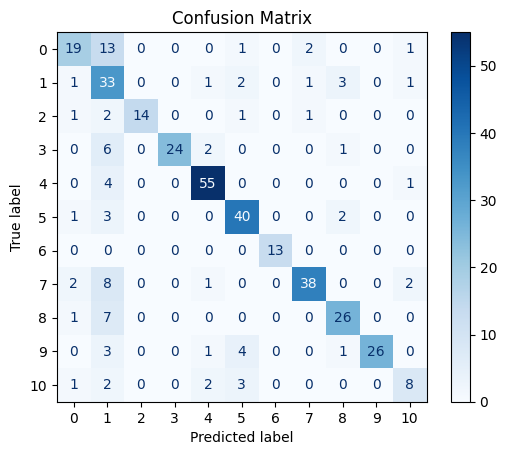

In [151]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()